## Imports
---

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, wavetrend3d, atr
from src.backtesting_lib import evaluatePairs
import pandas_ta as ta
from scipy.signal import argrelextrema
import csv

## Getting the Data
---

In [5]:
auxusd = pd.read_csv("./data_directory/AUXUSD.csv")
auxusd['timestamp'] = pd.to_datetime(auxusd['timestamp'], unit='ms')
auxusd['timestamp'] = pd.to_datetime(auxusd['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
auxusd.set_index('timestamp', inplace=True)
auxusd.drop_duplicates(inplace=True)

In [4]:
usdjpy = pd.read_csv("./data_directory/USDJPY.csv")
usdjpy['timestamp'] = pd.to_datetime(usdjpy['timestamp'], unit='ms')
usdjpy['timestamp'] = pd.to_datetime(usdjpy['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
usdjpy.set_index('timestamp', inplace=True)
usdjpy.drop_duplicates(inplace=True)

In [3]:
eurgbp = pd.read_csv("./data_directory/EURGBP.csv")
eurgbp['timestamp'] = pd.to_datetime(eurgbp['timestamp'], unit='ms')
eurgbp['timestamp'] = pd.to_datetime(eurgbp['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
eurgbp.set_index('timestamp', inplace=True)
eurgbp.drop_duplicates(inplace=True)

In [3]:
forex_data = pd.read_csv("./data_directory/EURUSD_2021_2023.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data.drop_duplicates(inplace=True)

In [2]:
eurusd = pd.read_csv("./data_directory/EURUSD_NEW.csv")
eurusd.set_index("Date", inplace=True)
eurusd.index = pd.to_datetime(eurusd.index)
eurusd.drop_duplicates(inplace=True)

# Kleines Tutorial für Backtesting.py

Es besteht aus einen init part wo alle variablen definiert und initialisiert werden und einen next part wo der algorithmus nach und nach jede candle durchgeht. Dabei kann man die zurzeitige Candle mit __self.data.Close[-1]__ abrufen. Dir davor mit -2 usw. Ihr könnt außerdem dabei zwischen Close, Open, High, Low entscheiden. 

Um die zurzeitige Balance zu bekommen ruft ihr self.equity auf. 

Um Indicatoren hinzuzufügen habt ihr folgende Syntax:

__self.IndicatorName = self.I(Indicator, Parameter1, Parameter2, ...)__

Dabei könnt ihr die jetzigen Werte abrufen wie mit den Daten [-n],  $n \in \mathbb{N}$ .

Um Trades einzugehen bentzt man entweder:

__self.buy(size=deineGroesse)__ 

__self.sell(size=deineGroesse)__

Ihr müsst dabei geachten das man entweder die Share anzahl als Integer übergebt oder die eine Kommazahl von $[0,1)$ die darstellt wie viel Prozent deines Portfolios du reinsetzt hast.

um eine Position zu schließen benutzt ihr: 

__self.position.close()__

Das sind so die wichtigsten Befehle. Leider lässt die libary nicht mehrere Positionen gleichzeitig. Falls ihr das umbedingt braucht kann ich nach einer anderen Libary ausschau halten. 

Falls ihr irgendwelche anderen Befehle braucht wie z.B. eine LimitOrder oder sowas dann findet ihr die unter den Documentations: 

- https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0


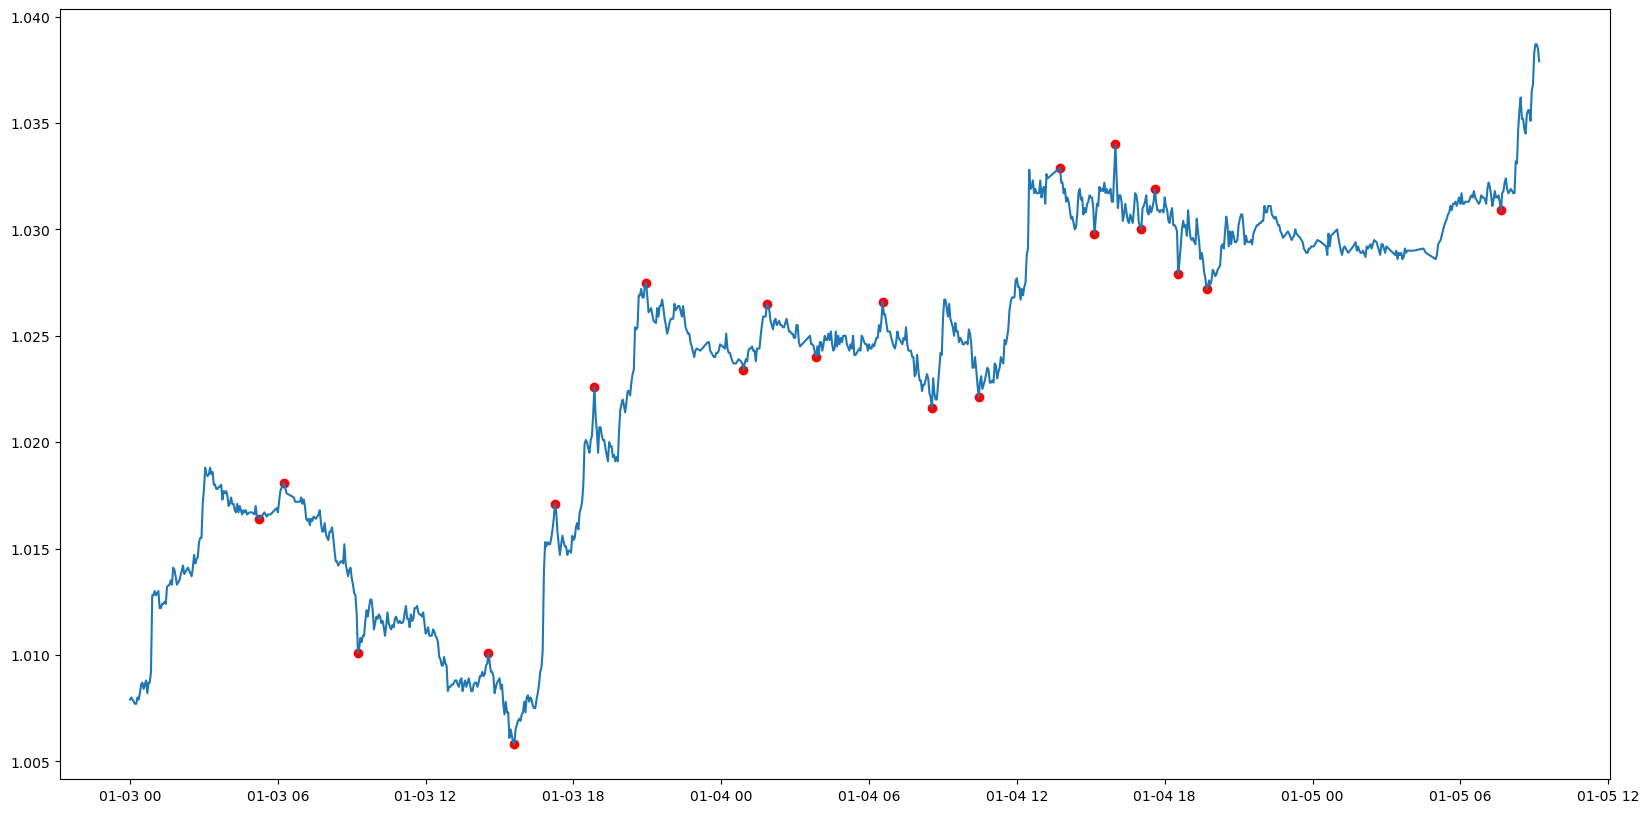

In [16]:
indexes = argrelextrema(eurusd['Close'][:1000].values, np.greater, order=20)[0]
values = eurusd['Close'][:1000].iloc[indexes]

indexeslower = argrelextrema(eurusd['Close'][:1000].values, np.less, order=20)[0]
valueslower = eurusd['Close'][:1000].iloc[indexeslower]

plt.figure(figsize=(20,10))
plt.plot(eurusd['Close'][:1000])
plt.scatter(values.index, values.values, c='r')
plt.scatter(valueslower.index, valueslower.values, c='r')

/Users/dennisschielke/Desktop/Philip/src/indicators.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["btmm"] = swings_data_btm
/Users/dennisschielke/Desktop/Philip/src/indicators.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["btmm"].replace(0, np.nan, inplace=True)
/Users/dennisschielke/Desktop/Philip/src/indicators.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

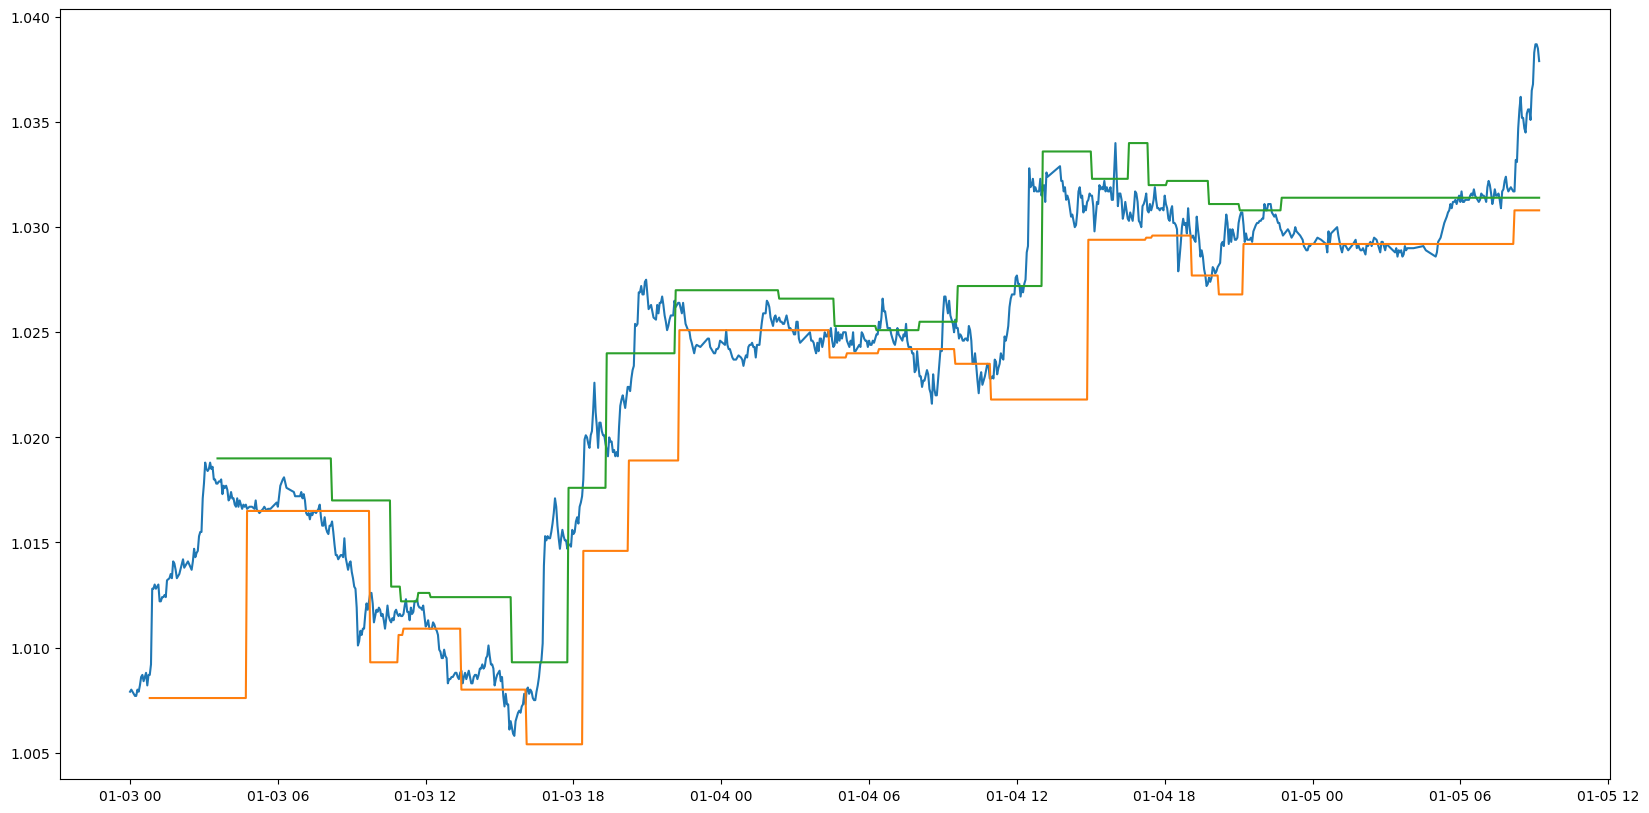

In [19]:
upperline = smc(eurusd[:1000], 10, 0, "3T")
lowerline = smc(eurusd[:1000], 10, 1, "3T")

plt.figure(figsize=(20,10))
plt.plot(eurusd[:1000]['Close'])
plt.plot(upperline)
plt.plot(lowerline)
plt.show()


## The Strategy
---

In [103]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import warnings
import numpy as np

warnings.filterwarnings("ignore")

class WL(Strategy):
    atr_window = 13
    tradehourStart = 0
    tradehourEnd = 23
    candlecountEntry = 10
    def init(self):
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.lastdiffs = []
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.atr = self.I(atr, self.data.df, self.atr_window)
        self.trade_opened = False
        self.sholong = 0
        self.tagged = False
        self.taggeddev = 0
        self.idk = self.data.df
        self.wavetrendMirror = self.I(wavetrend3d, self.idk, 5,False,"4H", True)
        self.wavetrend = self.I(wavetrend3d, self.idk, 5,False ,"4H", False)
        self.stoploss = 0
        self.taggedcounter = 0
        self.supertrendu = self.I(supertrend, self.data.df, 10, 2.5, 0)
        self.supertrendl = self.I(supertrend, self.data.df, 10, 2.5, 1)
        

    def next(self):
        if not self.trade_opened and self.data.index[-1].hour >= self.tradehourStart and self.data.index[-1].hour <= self.tradehourEnd:
            if((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                if self.wavetrendMirror[-1] > self.wavetrend[-1]:
                    self.tagged = True
                    if(self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)):
                        self.taggeddev = 2
                    else:
                        self.taggeddev = 3
                    self.sholong = 1
            elif((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                if self.wavetrendMirror[-1] < self.wavetrend[-1]:
                    self.tagged = True
                    if(self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)):
                        self.taggeddev = 2
                    else:
                        self.taggeddev = 3
                    self.sholong = 0
            elif (self.tagged == True and self.sholong == 1):
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.High[-1] > self.vwapu2[-1] + (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.High[-1] > self.vwapu3[-1] + (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                if self.taggedcounter < self.candlecountEntry:
                    if ha_open > (ha_high - ((ha_high - ha_low)*0.12) and self.data.Close[-1]>self.vwapu1[-1]):
                        self.trade_opened = True
                        self.stoploss = self.data.Close[-1] + (self.atr[-1]/2)
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.000001):
                                diff = 0
                            self.lastdiffs.append(diff)
                            if(diff == 0):
                                size = 0
                            else: 
                                size = abs((kapital/10000) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.buy(size=sizeO)
                    self.taggedcounter += 1
                else: 
                    self.tagged = False
                    self.taggedcounter = 0                    
            elif (self.tagged == True and self.sholong == 0):
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.Low[-1] < self.vwapl2[-1] - (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.Low[-1] < self.vwapl3[-1] - (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < self.candlecountEntry:
                        if ha_open < (ha_low + (ha_high - ha_low) * 0.12) and self.data.Close[-1]<self.vwapl1[-1]:
                            self.stoploss = self.data.Close[-1] - (self.atr[-1]/2)
                            self.trade_opened = True
                            def berechnen(kapital, stoploss, entry):
                                diff = abs(stoploss - entry)
                                if(diff < 0.000001):
                                    diff = 0
                                self.lastdiffs.append(diff)
                                if(diff == 0):
                                    size = 0
                                else: 
                                    size = abs((kapital/10000) / abs(diff))
                                return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            self.sell(size=sizeO)
                        else: 
                            self.tagged = False
                            self.taggedcounter = 0
                        self.taggedcounter += 1
        elif self.trade_opened:
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Close[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.Close[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False


In [104]:
bt = Backtest(eurusd, WL, cash=1000000, commission=0.00, exclusive_orders=True)
output = bt.run()
output

Start                     2000-01-03 00:00:00
End                       2019-12-31 22:57:00
Duration                   7302 days 22:57:00
Exposure Time [%]                   16.352097
Equity Final [$]                1327618.61868
Equity Peak [$]                  1332113.1373
Return [%]                          32.761862
Buy & Hold Return [%]               11.291795
Return (Ann.) [%]                    1.379452
Volatility (Ann.) [%]                1.527738
Sharpe Ratio                         0.902937
Sortino Ratio                        1.216332
Calmar Ratio                         0.490417
Max. Drawdown [%]                   -2.812812
Avg. Drawdown [%]                    -0.05818
Max. Drawdown Duration     1211 days 03:33:00
Avg. Drawdown Duration        3 days 20:10:00
# Trades                                19858
Win Rate [%]                         75.15359
Best Trade [%]                       0.690072
Worst Trade [%]                     -2.181161
Avg. Trade [%]                    

In [100]:
bt.plot()

GridPlot(id='p24262', ...)

In [97]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import warnings
import numpy as np

warnings.filterwarnings("ignore")



class PIES(Strategy):

    #Hier die Werte die ihr abändern könnt
    shorts = True
    longs = True
    candlecountEntry = 10 # Nach wie vielen noch geschaut wird ob buy/sell signal kommt
    stoplossCandles = 5 # Beim Entry -> Wie viele candles er nach hinten schauen soll für sl
    tradehourStart = 6 #UTC Time
    tradehourEnd = 22 #UTC Time
    wavetrendOn = True
    atr_window = 13
    stoplossratio = 0.5
    timeframeOBs = "15T"  #T for Minute and H for Hour
    timeframeWavetrend = "15T"
    cockOn = False
    cockSize = 6
    feesOn = True

    def init(self):
        # Store orderblock values
        self.orderblocksU = []
        self.orderblocksB = []
        self.startKap = self.equity
        # If orderblock got hit and price is above/below upperbands/lowerbands
        self.tagged = False
        self.taggedprice = 0
        self.taggeddev = 0
        self.lastdiffs = []
        self.length = len(self.data.df)
        # Counter of how many candles it was ago when orderblock got tagged
        self.taggedcounter = 0
        # Overall candle count
        self.candlecount = 17
        self.trade_opened = False
        self.index = 0
        self.fees = 0
        self.log = []
        self.kapitalverfolgung = 1000000
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        # Values that act as a buffer for the orderblocks after they got hit
        self.orderblocklow = 0
        self.orderblockhigh = 0 
        self.done = True
        self.lastKapital = self.equity
        self.idk = self.data.df
        self.enter = 0
        # Supertrend Indicator
        self.supertrendu = self.I(supertrend, self.data.df, 10, 2.5, 0)
        self.supertrendl = self.I(supertrend, self.data.df, 10, 2.5, 1)
        # VWAP Indicator
        self.upperOB = self.I(smc, self.data.df, length=5, band=1, timeframe=self.timeframeOBs)
        self.lowerOB = self.I(smc, self.data.df, length=5, band=0, timeframe=self.timeframeOBs)
        self.wavetrendMirror = self.I(wavetrend3d, self.idk, self.cockSize,self.cockOn ,self.timeframeWavetrend, True)
        self.wavetrend = self.I(wavetrend3d, self.idk, self.cockSize,self.cockOn ,self.timeframeWavetrend, False)
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.prevvalueU = 0
        self.prevvalueB = 0
        # ATR Indicator
        self.atr = self.I(atr, self.data.df, self.atr_window)

    def next(self):
        # Add orderblocks
        if(len(self.orderblocksB) > 0):
            if(self.candlecount - self.orderblocksB[0][2] > 1000 and len(self.orderblocksB) > 1):
                self.orderblocksB = self.orderblocksB[1:]
        if(len(self.orderblocksU) > 0):
            if(self.candlecount - self.orderblocksU[0][2] > 1000 and len(self.orderblocksU) > 1):
                self.orderblocksU = self.orderblocksU[1:]
        if(self.upperOB[-1] > 0 and self.upperOB[-1] != self.prevvalueU):
            self.orderblocksU.append([self.data.High[-10], self.data.Low[-10], self.candlecount])
            self.prevvalueU = self.upperOB[-1]
        if(self.lowerOB[-1] > 0 and self.lowerOB[-1] != self.prevvalueB):
            self.orderblocksB.append([self.data.High[-10], self.data.Low[-10], self.candlecount])
            self.prevvalueB = self.lowerOB[-1]
        # If no trade is open
        if not self.trade_opened and self.data.index[-1].hour >= self.tradehourStart and self.data.index[-1].hour <= self.tradehourEnd:
            # If it didnt hit orderblock + upper/lower band yet
            if self.tagged==False:
                # For loops to iterate through the orderblocks and check if they got hit
                if self.shorts:
                    if self.wavetrendMirror[-1] > self.wavetrend[-1] or self.wavetrendOn == False:
                        for high, low, candle in self.orderblocksU:
                            if self.data.High[-1] > low and self.data.High[-1] < high and self.candlecount - candle < 1000 and ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                                self.tagged = True
                                if(self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)):
                                    self.taggeddev = 2
                                else:
                                    self.taggeddev = 3
                                self.taggedprice = self.data.High[-1]
                                self.orderblocklow = low
                                self.sholong = 1
                                self.orderblocksU.remove([high, low, candle])
                                break
                if self.longs:
                    if self.wavetrendMirror[-1] < self.wavetrend[-1] or self.wavetrendOn == False:
                        for high, low, candle in self.orderblocksB:
                            if self.data.Low[-1] < high and self.data.Low[-1] > low and self.candlecount - candle < 1000 and ((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                                self.tagged = True
                                if(self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)):
                                    self.taggeddev = 2
                                else:
                                    self.taggeddev = 3
                                self.orderblockhigh = high
                                self.sholong = 0
                                self.taggedprice = self.data.Low[-1]
                                self.orderblocksB.remove([high, low, candle])
                                break

            # If it hit and we have to go short
            elif (self.tagged == True and self.sholong == 1):
                # Heikin Ashi Candles)
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.High[-1] > self.vwapu2[-1] + (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.High[-1] > self.vwapu3[-1] + (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < self.candlecountEntry:
                        if self.data.High[-1] < self.orderblocklow and ha_open > (ha_high - ((ha_high - ha_low)*0.12) and self.data.Close[-1]>self.vwapu1[-1]):
                            self.trade_opened = True
                            self.stoploss = 0
                            for i in range(1, self.stoplossCandles):
                                if self.data.High[-i] > self.stoploss:
                                    self.stoploss = self.data.High[-i]
                            def berechnen(kapital, stoploss, entry):
                                    diff = abs(stoploss - entry)

                                    if(diff < 0.0000001):
                                        diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                                    self.lastdiffs.append(diff)
                                    size = abs((kapital/10000) / abs(diff))
                                    return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            try:
                                if(self.data.Close[-1]*sizeO < self.kapitalverfolgung):
                                    self.kapitalverfolgung = self.kapitalverfolgung - self.data.Close[-1]*sizeO
                                    self.index += 1
                                    self.enter = self.data.Close[-1]
                                    self.done = False
                                self.sell(size=sizeO)
                                if self.feesOn:
                                    self.fees += sizeO * self.data.Close[-1] * 3 / 100000
                            except:
                                print("Something went wrong")
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
            # If it hit and we have to go long
            elif (self.tagged == True and self.sholong == 0):
                # Heikin Ashi Candles
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.Low[-1] < self.vwapl2[-1] - (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.Low[-1] < self.vwapl3[-1] - (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < self.candlecountEntry:
                        if self.data.Low[-1] > self.orderblockhigh and ha_open < (ha_low + (ha_high - ha_low) * 0.12) and self.data.Close[-1]<self.vwapl1[-1]:
                            self.stoploss = 1000000 # Set stoploss to high value
                            self.trade_opened = True
                            for i in range(1, self.stoplossCandles):
                                if self.data.Low[-i] < self.stoploss:
                                    self.stoploss = self.data.Low[-i]
                            def berechnen(kapital, stoploss, entry):
                                diff = abs(stoploss - entry)
                                if(diff < 0.0000000001):
                                    diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                                self.lastdiffs.append(diff)
                                size = abs((kapital/10000) / abs(diff))
                                return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            try:
                                if(self.data.Close[-1]*sizeO < self.kapitalverfolgung):
                                    self.kapitalverfolgung = self.kapitalverfolgung - self.data.Close[-1]*sizeO
                                    self.index += 1
                                    self.enter = self.data.Close[-1]
                                    self.done = False
                                self.buy(size=sizeO)
                                if self.feesOn:
                                    self.fees += sizeO * self.data.Close[-1] * 3 / 100000
                            except:
                                print("Something went wrong")
                            self.trade_opened = True
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
        
        elif self.trade_opened: # Stop loss path
            if self.sholong == 0:
                if(self.data.Low[-1] < self.stoploss and not self.done):
                    temp = self.stoploss * abs(self.position.size)
                    fees = temp - (temp * 3/100000)
                    self.kapitalverfolgung = self.kapitalverfolgung + fees
                    self.done = True
                    self.log.append([self.data.index[-1], self.index, self.kapitalverfolgung, self.position.size, self.enter, self.stoploss, "Long", self.kapitalverfolgung - self.lastKapital])
                    self.lastKapital = self.kapitalverfolgung
                elif(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0 and not self.done):
                    temp = self.data.Close[-1] * abs(self.position.size)
                    fees = temp - (temp * 3/100000)
                    self.kapitalverfolgung = self.kapitalverfolgung + fees
                    self.done = True
                    self.log.append([self.data.index[-1], self.index, self.kapitalverfolgung, self.position.size, self.enter, self.stoploss, "Long", self.kapitalverfolgung - self.lastKapital])   
                    self.lastKapital = self.kapitalverfolgung
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Close[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.data.High[-1] > self.stoploss and not self.done):
                    temp = (self.enter - (self.stoploss - self.enter)) * abs(self.position.size)
                    fees = temp - (temp * 3/100000)
                    self.kapitalverfolgung = self.kapitalverfolgung + fees
                    self.done = True
                    self.log.append([self.data.index[-1], self.index, self.kapitalverfolgung, self.position.size, self.enter, self.stoploss, "Short", self.kapitalverfolgung - self.lastKapital])
                    self.lastKapital = self.kapitalverfolgung
                elif(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0 and not self.done):
                    temp = (self.enter + (self.enter - self.data.Close[-1])) * abs(self.position.size)
                    fees = temp - (temp * 3/100000)
                    self.kapitalverfolgung = self.kapitalverfolgung + fees
                    self.done = True
                    self.log.append([self.data.index[-1], self.index, self.kapitalverfolgung, self.position.size, self.enter, self.stoploss, "Short", self.kapitalverfolgung - self.lastKapital])
                    self.lastKapital = self.kapitalverfolgung
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.Close[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
        self.candlecount = self.candlecount + 1
        if(len(self.data.Close) == self.length):
            print(f"Die Fees betragen: {self.fees}")
            headers = ['Time', 'Index', 'Equity', 'Shares', 'Entry', 'Stoploss', 'Short or Long', 'Profit']
            def save_list_as_csv(data_list, file_path):
                with open(file_path, "w", newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(headers)
                    for item in data_list:
                        formatted_row = [
                            str(item[0]),  # Convert the timestamp to string format
                            item[1],
                            "{:.4f}".format(item[2]), 
                            item[3],
                            "{:.5f}".format(item[4]),
                            "{:.5f}".format(item[5]),
                            item[6],
                            "{:.4f}".format(item[7])
                        ]
                        writer.writerow(formatted_row)
            folder_path = "./results_lists/"
            file_name = "list.csv"
            file_path = folder_path + file_name
            save_list_as_csv(self.log, file_path)

In [43]:
bt2 = Backtest(eurusd, PIES, cash=1000000, commission=0.00, exclusive_orders=True)
output2 = bt2.run()
output2

Die Fees betragen: 4022.8436830002042


Start                     2000-01-03 00:00:00
End                       2019-12-31 22:57:00
Duration                   7302 days 22:57:00
Exposure Time [%]                    1.126147
Equity Final [$]                 993919.09295
Equity Peak [$]                  1001917.5252
Return [%]                          -0.608091
Buy & Hold Return [%]               11.291795
Return (Ann.) [%]                   -0.029566
Volatility (Ann.) [%]                0.151696
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.806106
Avg. Drawdown [%]                   -0.047867
Max. Drawdown Duration     6724 days 08:24:00
Avg. Drawdown Duration      270 days 10:14:00
# Trades                                  740
Win Rate [%]                        29.459459
Best Trade [%]                       1.701783
Worst Trade [%]                     -0.893589
Avg. Trade [%]                    

In [36]:
bt2.plot()

GridPlot(id='p7914', ...)

# Parameter Optimization
---

In [29]:
bt = Backtest(usdjpy, PIES, cash=1000000, commission=0.00, exclusive_orders=True)
output = bt.run()

stats, heatmap = bt.optimize(
    timeframeOBs = ["3T", "15T", "30T", "1H"],
    timeframeWavetrend = ["3T", "15T", "30T", "1H", "2H", "4H"],
    maximize='Sharpe Ratio',
    max_tries=100,
    return_heatmap=True,
    random_state=0,
)

  0%|          | 0/8 [00:00<?, ?it/s]

## Get 3 best results

In [31]:
hm = heatmap.groupby(['timeframeWavetrend', 'timeframeOBs']).mean().unstack()
hm

timeframeOBs,15T,1H,30T,3T
timeframeWavetrend,,,,
15T,0.111697,0.000000,0.304934,0.000000
1H,0.761833,0.281731,0.311259,0.000000
2H,0.912780,0.424975,0.588096,0.142120
30T,0.693580,0.356641,0.415475,0.112197
3T,0.379758,0.101599,0.598511,0.000000
4H,1.114119,0.640418,1.012977,0.000000


<Axes: xlabel='timeframeOBs', ylabel='timeframeWavetrend'>

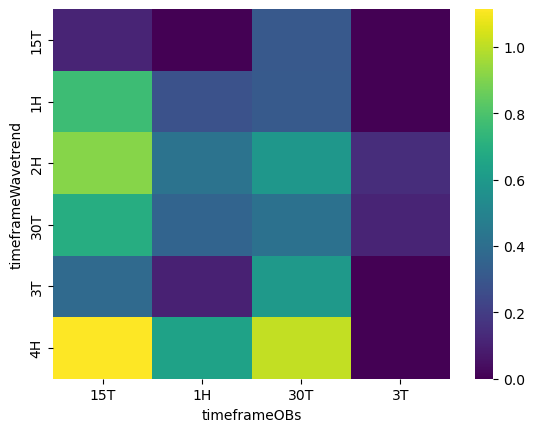

In [32]:
%matplotlib inline

sns.heatmap(hm[::1], cmap='viridis')

# Plotting and evaluating CSVs
---

In [39]:

# read csv file from results_lists folder
df = pd.read_csv('./results_lists/list.csv')

def calculate_rrr(profits_df):
    # Filter positive and negative profits
    gains = profits_df[profits_df['Profit'] > 0]['Profit']
    losses = profits_df[profits_df['Profit'] < 0]['Profit']

    # Calculate average gain and average loss
    average_gain = gains.mean()
    average_loss = losses.mean()

    # Calculate RRR
    rrr = abs(average_gain / average_loss)

    return rrr

calculate_rrr(df)

0.45432558079600766

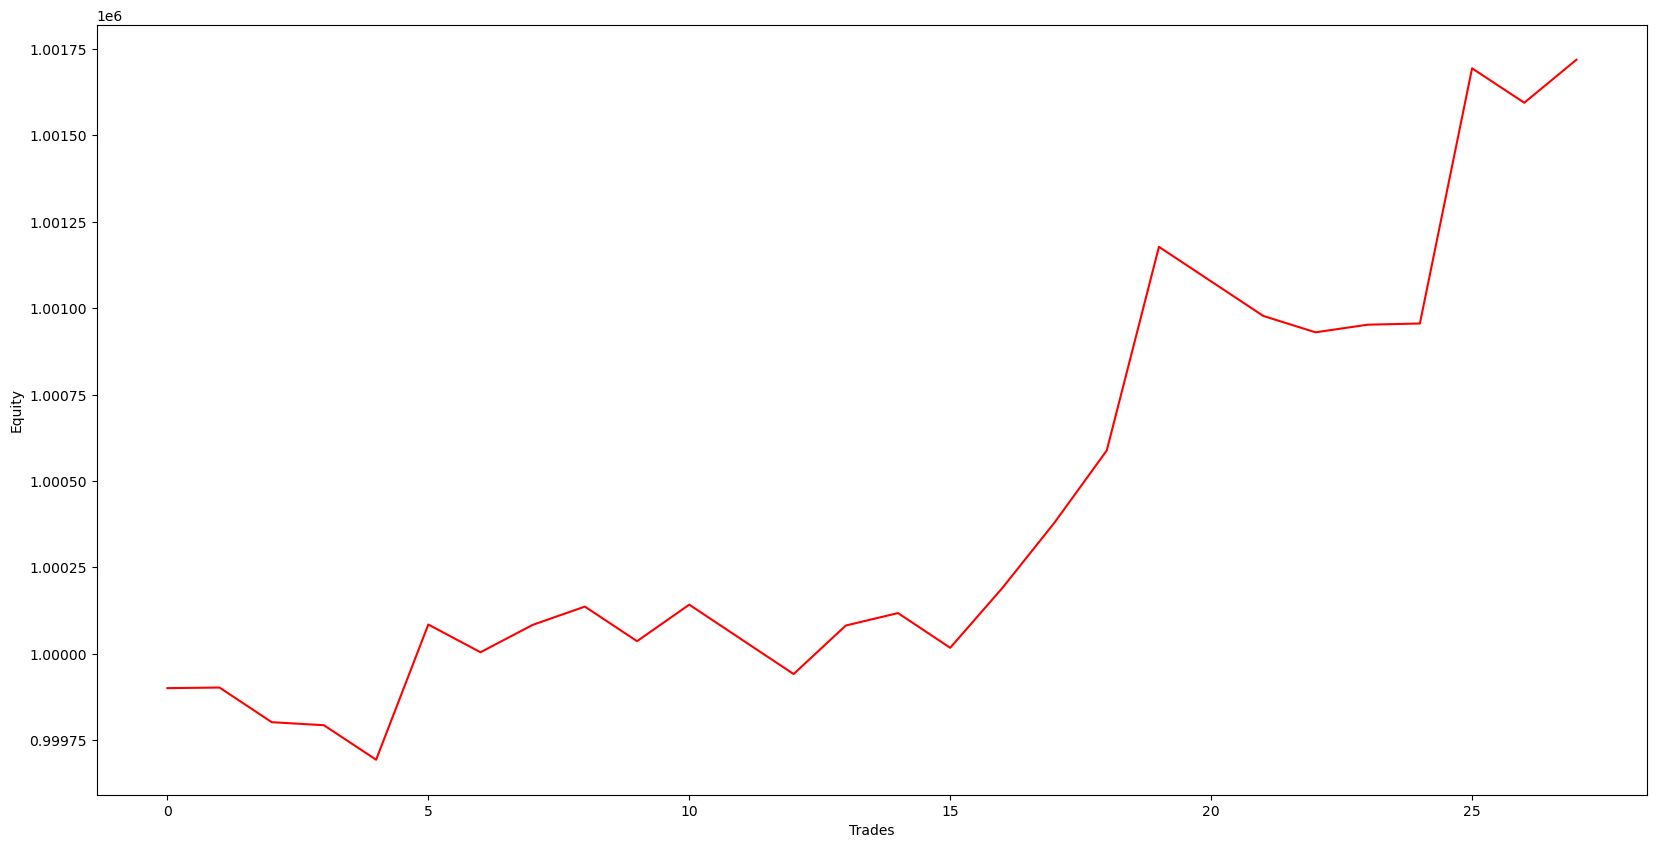

In [9]:
df = pd.read_csv('./results_lists/list.csv')

plt.figure(figsize=(20, 10))
plt.plot(df['Equity'], color='red') 
plt.xlabel('Trades')  
plt.ylabel('Equity') 
plt.show()

# Backtesting multiple pairs at the same time
---

In [ ]:
pairsList = ["AUXUSD", "EURUSD_2021_2023"]
 
evaluatePairs(pairsList, PIES)